In [1]:
# Imports
from music21 import converter, instrument, note, chord, stream, midi
import glob
import time
import numpy as np
import keras.utils as utils
import pandas as pd

# Music Generation with an RNN

- Music is a complex phenomenon with many representations (e.g., digital audio, musical scores, lead sheets)
- A simple representation of music is as a sequence of notes and rests:
    - (equivalent to one line of melody)
- This can be one-hot encoded and applied to a CharRNN!

## A simple music representation

- Our musical representation is going be a sequence of integers between 0 and 129.
- Each integer represents a musical instruction lasting for one sixteenth note (one semiquaver) of duration.
    - This is a typical level of detail for electronic music sequencers.
- MIDI is a standard way of encoding instructions for synthesised instruments and can represent whole musical scores.
    - Standard MIDI allows 128 pitches (there are only 88 on a piano keyboard) where number 60 is 'middle C'.
    
#### Melody-RNN Encoding

- 0-127 play a note at that MIDI note number. (`MELODY_NOTE_ON`)
- 128 stop whatever note was playing. (`MELODY_NOTE_OFF`)
- 129 do nothing. (`MELODY_NO_EVENT`)
    
This encoding should allow long notes (a note-on followed by one or more no-change events, then a note-off), and rests (a note-off followed by one or more no-change events).

Here's a standard melody converted into this format:

![](figures/wm_score_example.png)

NB: Google's [Magenta project](https://magenta.tensorflow.org/) have created some really great musical RNNs, with lots of advanced features. This script focusses on simplicity and clarity instead!

### Convert between MIDI files and numpy arrays in melody format

- Music is more complex than text (e.g., more than one note might happen at once). 
- We use the Music21 library to read MIDI music filescand then convert to our Melody-RNN format.
- The functions below turn a Music21 "stream" (of notes) into a numpy array of 8-bit integers.
- All complex rhythms are simplified to sixteenth note versions.
- Chords are simplified to the highest note.



In [2]:
# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output


def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream


In [ ]:
## Play a melody stream
# sp = midi.realtime.StreamPlayer(melody_stream)
# sp.play()

In [ ]:
# for setting up musescore and musicxml rendering on linux:
# from music21 import environment
# us = environment.UserSettings()
# us.create()
# us['musescoreDirectPNGPath'] = '/usr/bin/mscore3'
# us['musicxmlPath'] = '/usr/bin/mscore3'

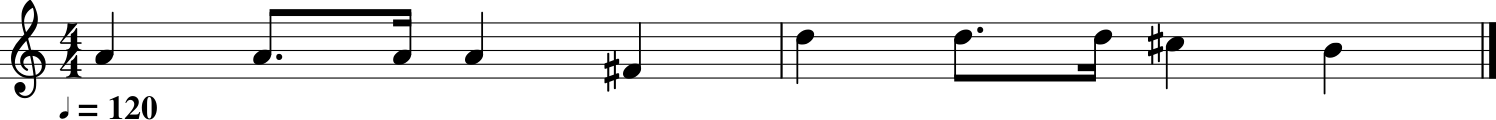

[ 69 129 129 129  69 129 129  69  69 129 129 129  66 129 129 129  74 129
 129 129  74 129 129  74  73 129 129 129  71 129 129 129 128]


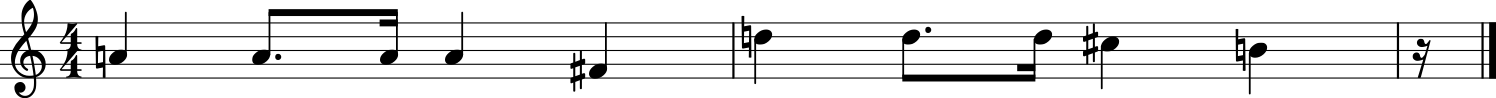

In [3]:
wm_mid = converter.parse("../datasets/waltzing-matilda.mid")
wm_mid.show()
wm_mel_rnn = streamToNoteArray(wm_mid)
print(wm_mel_rnn)
noteArrayToStream(wm_mel_rnn).show()

## Construct a dataset of popular melodies

Open some midi files and extract the melodies as numpy note sequence arrays.

In [ ]:
import time
midi_files = glob.glob("../datasets/*.mid") # this won't work, no files there.

training_arrays = []
for f in midi_files:
    start = time.perf_counter()
    try:
        s = converter.parse(f)
    except:
        continue
#     for p in s.parts: # extract all voices
#         arr = streamToNoteArray(p)
#         training_arrays.append(p)
    arr = streamToNoteArray(s.parts[0]) # just extract first voice
    training_arrays.append(arr)
    print("Converted:", f, "it took", time.perf_counter() - start)

training_dataset = np.array(training_arrays)
np.savez('melody_training_dataset.npz', train=training_dataset)

# Load Training Data and Create RNN

In the following we load in the training dataset, slice the melodies into example sequences and build our Melody RNN.

In [4]:
# Training Hyperparameters:
VOCABULARY_SIZE = 130 # known 0-127 notes + 128 note_off + 129 no_event
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 30
SEED = 2345  # 2345 seems to be good.
np.random.seed(SEED)

## Load up some melodies I prepared earlier...
with np.load('../datasets/melody_training_dataset.npz', allow_pickle=True) as data:
    train_set = data['train']

print("Training melodies:", len(train_set))

Training melodies: 186


In [5]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

# Prepare training data as X and Y.
# This slices the melodies into sequences of length SEQ_LEN+1.
# Then, each sequence is split into an X of length SEQ_LEN and a y of length 1.

# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

# Look at the size of the training corpus:
print("Total Training Corpus:")
print("X:", X.shape)
print("y:", y.shape)
print()

# Have a look at one example:
print("Looking at one example:")
print("X:", X[95])
print("y:", y[95])
# Note: Music data is sparser than text, there's lots of 129s (do nothing)
# and few examples of any particular note on.
# As a result, it's a bit harder to train a melody-rnn.

Total Training Corpus:
X: (122250, 30)
y: (122250,)

Looking at one example:
X: [129 128 129 129 129 129 129  43 129  35 129 129 129  38 129 129 129 128
 129 129 129 129 129  31 129  43 129 129 129  41]
y: 129


Number of notes:
(128174,)
Notes that do appear:
[ 29  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 128 129]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  30 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127]
Plot the relative occurences of each note:


Text(0, 0.5, 'occurences (log scale)')

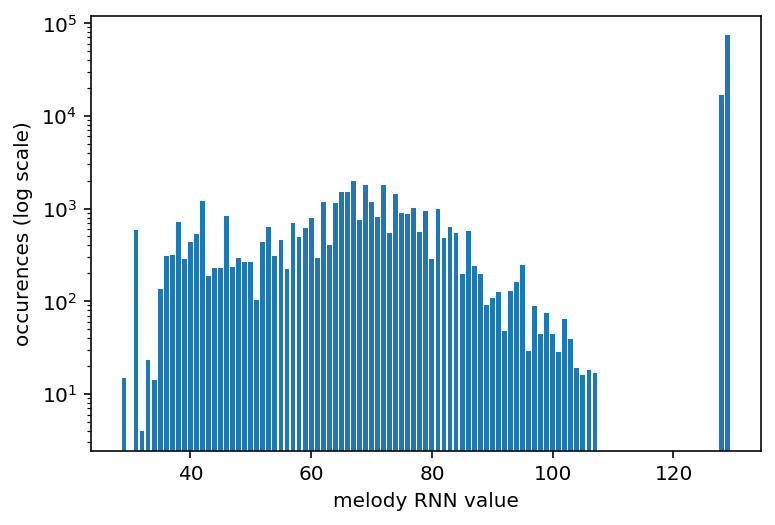

In [6]:
# Do some stats on the corpus.
all_notes = np.concatenate(train_set)
print("Number of notes:")
print(all_notes.shape)
all_notes_df = pd.DataFrame(all_notes)
print("Notes that do appear:")
unique, counts = np.unique(all_notes, return_counts=True)
print(unique)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique))

print("Plot the relative occurences of each note:")
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('dark_background')
plt.bar(unique, counts)
plt.yscale('log')
plt.xlabel('melody RNN value')
plt.ylabel('occurences (log scale)')

# Define the Training RNN

- The training RNN will be more complex than in the text examples.
- Using 2 layers of LSTM 256 LSTM cells each.
- Using an Embedding layer on the input (saves some effort in creating one-hot examples)
- Using sparse categorical cross entropy for loss (so that ys don't have to be one-hot)

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

# build the model: 2-layer LSTM network.
# Using Embedding layer and sparse_categorical_crossentropy loss function 
# to save some effort in preparing data.

print('Build model...')
model_train = Sequential()
model_train.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN))

# LSTM part
model_train.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_train.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_train.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_train.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_train.summary()

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 256)           33280     
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 130)               33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Training

- I trained this model on Google's Colaboratory system (free online Python machine learning environment, including GPU).
- Good to train for lots of epochs, I tried for 100: less is possible.
- Takes around 3 minutes per epoch on an NVidia K80 GPU = 5 hours to train.

Here's the training diagram:

<img src="figures/training_melody_rnn.png" style="width: 600px;"/>

Probably could have stopped after about 50 epochs to save some time!

This trained model is included in the repo, so you can go ahead and load that, or train again with your own dataset.

In [ ]:
# Train the model (this takes time)
model_train.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)
model_train.save("zeldic-rnn.h5")

In [ ]:
# Load if necessary - don't need to do this.
# model_train = keras.models.load_model("zeldic-rnn.h5")

# Decoding Model

Now we build a 1-in, 1-out model for encoding. This is the same model as for training, just with a input length of 1, and LSTM statefulness turned on.

- Much faster to use the network with this model!
- The weights are loaded directly from the saved `train_model` file.

In [8]:
# Build a decoding model (input length 1, batch size 1, stateful)
model_dec = Sequential()
model_dec.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=1, batch_input_shape=(1,1)))
# LSTM part
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True, return_sequences=True))
model_dec.add(LSTM(HIDDEN_UNITS, stateful=True))

# project back to vocabulary
model_dec.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_dec.summary()
# set weights from training model
#model_dec.set_weights(model_train.get_weights())
model_dec.load_weights("zeldic-rnn.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, 1, 256)               33280     
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 256)               525312    
_________________________________________________________________
lstm_3 (LSTM)                (1, 256)                  525312    
_________________________________________________________________
dense_1 (Dense)              (1, 130)                  33410     
Total params: 1,117,314
Trainable params: 1,117,314
Non-trainable params: 0
_________________________________________________________________


# Sampling from the Model

- We need define two functions for sampling:
    - `sample`: samples from the categorical distribution output by the model, with a diversity adjustment procedure.
    - `sample_model`: samples number of notes from the model using a one-note seed.

In [10]:
def sample(preds, temperature=1.0):
    """ helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Sampling function

def sample_model(seed, model_name, length=400, temperature=1.0):
    '''Samples a musicRNN given a seed sequence.'''
    generated = []  
    generated.append(seed)
    next_index = seed
    for i in range(length):
        x = np.array([next_index])
        x = np.reshape(x,(1,1))
        preds = model_name.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature)        
        generated.append(next_index)
    return np.array(generated)

# Let's sample some music!

- Generate 127 notes + the starting note 60 (middle C) - this corresponds to 8 bars of melody
- Turn the sequence back into a music21 stream
- Show as musial score, play it back, or save as a MIDI file!



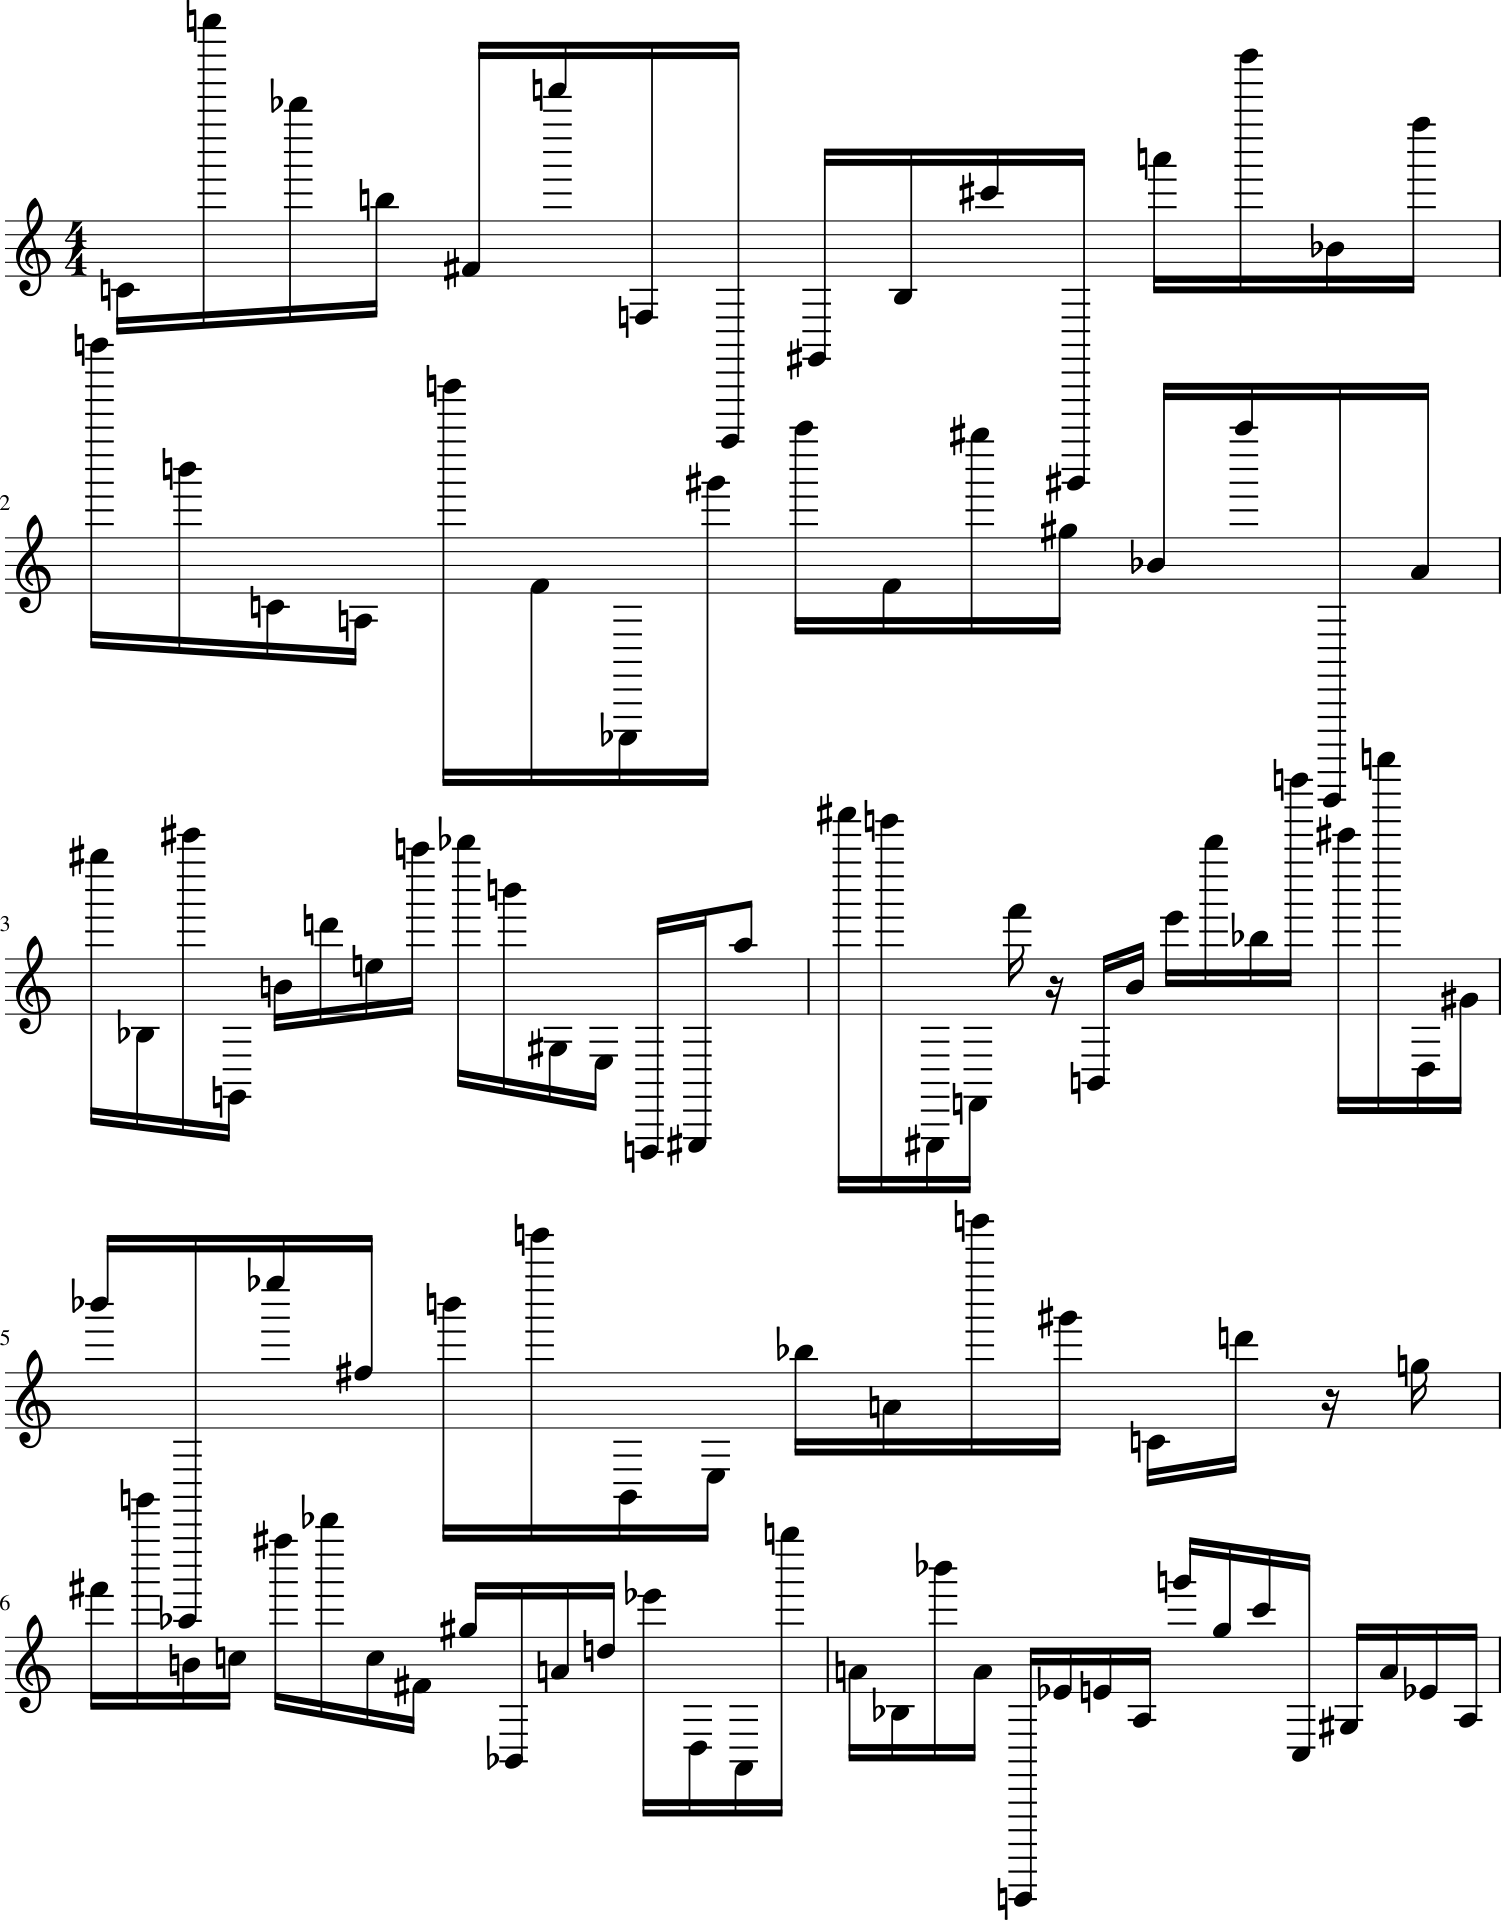

In [21]:
model_dec.reset_states() # Start with LSTM state blank
o = sample_model(60, model_dec, length=127, temperature=15.0) # generate 8 bars of melody

melody_stream = noteArrayToStream(o) # turn into a music21 stream
melody_stream.show() # show the score.


### Score example:

<!-- ![](figures/music_example.png) -->

# Play generated Melody

music21 can even play back a generated melody right in Jupyter! Cool!

In [22]:
## Pay a melody stream
sp = midi.realtime.StreamPlayer(melody_stream)
sp.play()

In [ ]:
# figure out where the user settings are kept.
from music21 import *
us = environment.UserSettings()
us.getSettingsPath()